# Test statistics

We define two test statistics. 

The first flattens all normalized compatibility scores across all 11 379 metrical positions, and takes the mean.

Let $T_{pos}$ denote this statistic:

$$ T_{pos} = \frac{1}{11 379} \sum_{pos=1}^{11 379} \bar{x}_{pos}.$$

To avoid longer songs weighing more, we also define a second test statistic that first averages the normalized compatibility scores within each song, and then takes the mean again across the 40 songs. 

Let $T_{song}$ denote this statistic:

$$ T_{song} = \frac{1}{40} \sum_{s=1}^{40} \bar{x}_s.$$

We are going to compute these test statistics for the Pindar corpus, and for 10 000 random baselines, and then perform a one-sided permutation test to see if the observed statistics are significantly higher than the baselines.


## Observed distribution (Pindar)

In [11]:
from pathlib import Path
ROOT = Path.cwd().parent

Let's start with $T_{pos}$ for the Pindar corpus. 

In [12]:
import pickle

from stats_comp import compatibility_corpus, compatibility_canticum, compatibility_ratios_to_stats

corpus_path = ROOT / 'data/compiled/triads'
corpus_path_strophes = ROOT / 'data/compiled/strophes/'
corpus_path_epodes = ROOT / 'data/compiled/epodes/'

corpus_score_pickle_path = ROOT / 'data/cache/all_comp_ratios.pkl'
corpus_score_pickle_path_strophes = ROOT / 'data/cache/all_comp_ratios_strophes.pkl'
corpus_score_pickle_path_epodes = ROOT / 'data/cache/all_comp_ratios_epodes.pkl'

if corpus_score_pickle_path.exists():
    with open(corpus_score_pickle_path, 'rb') as f:
        all_corpus_comp_scores = pickle.load(f)
else:
    print('Calculating all_corpus_comp_scores...')
    all_corpus_comp_scores = compatibility_corpus(corpus_path)
    with open(corpus_score_pickle_path, 'wb') as f:
        pickle.dump(all_corpus_comp_scores, f)

if corpus_score_pickle_path_strophes.exists():
    with open(corpus_score_pickle_path_strophes, 'rb') as f:
        all_corpus_comp_scores_strophes = pickle.load(f)
else:
    print('Calculating all_corpus_comp_scores_strophes...')
    all_corpus_comp_scores_strophes = compatibility_corpus(corpus_path_strophes)
    with open(corpus_score_pickle_path_strophes, 'wb') as f:
        pickle.dump(all_corpus_comp_scores_strophes, f)

if corpus_score_pickle_path_epodes.exists():
    with open(corpus_score_pickle_path_epodes, 'rb') as f:
        all_corpus_comp_scores_epodes = pickle.load(f)
else:
    print('Calculating all_corpus_comp_scores_epodes...')
    all_corpus_comp_scores_epodes = compatibility_corpus(corpus_path_epodes)
    with open(corpus_score_pickle_path_epodes, 'wb') as f:
        pickle.dump(all_corpus_comp_scores_epodes, f)

all_corpus_comp_scores_ba = compatibility_canticum(ROOT / 'data/compiled/extra/ba05.xml', 'ba05')

def count_leaves(obj):
    """Count all leaf (non-list) elements in a nested structure."""
    if isinstance(obj, list):
        return sum(count_leaves(item) for item in obj)
    else:
        return 1

# Calculate T_obs for each category
T_obs_pos_triads = compatibility_ratios_to_stats(all_corpus_comp_scores)
T_obs_triads_ba = compatibility_ratios_to_stats(all_corpus_comp_scores_ba) # For Bacchylides T_pos = T_song

T_obs_pos_strophes = compatibility_ratios_to_stats(all_corpus_comp_scores_strophes)
T_obs_pos_epodes = compatibility_ratios_to_stats(all_corpus_comp_scores_epodes)

# Count total number of variables
total_triads = sum(count_leaves(lst) for lst in all_corpus_comp_scores)
total_triads_ba = sum(count_leaves(lst) for lst in all_corpus_comp_scores_ba)
total_strophes = sum(count_leaves(lst) for lst in all_corpus_comp_scores_strophes)
total_epodes = sum(count_leaves(lst) for lst in all_corpus_comp_scores_epodes)

print ('--------------------------------------------')
print(f'\033[1;33mTRIADS\033[0m\n')
print(f'\033[33mPindar\033[0m: T_pos: \033[1;32m{T_obs_pos_triads:.3f}\033[0m')
print(f'Number of variables: {total_triads}')

print(f'\033[33mBacchylides\033[0m (Ba. 5) T (T_pos = T_song): \033[1;32m{T_obs_triads_ba:.3f}\033[0m')
print(f'Number of variables: {total_triads_ba}')
print ('--------------------------------------------')

print ('\n--------------------------------------------')
print(f'\033[1;33mSTROPHES\033[0m\n')
print(f'\033[33mPindar\033[0m: T_pos: \033[1;32m{T_obs_pos_strophes:.3f}\033[0m')
print(f'Number of variables: {total_strophes}')
print ('--------------------------------------------')

print ('\n--------------------------------------------')
print(f'\033[1;33mEPODES\033[0m\n')
print(f'\033[33mPindar\033[0m: T_pos: \033[1;32m{T_obs_pos_epodes:.3f}\033[0m')
print(f'Number of variables: {total_epodes}')
print ('--------------------------------------------')


--------------------------------------------
TRIADS

Pindar: T_pos: 0.412
Number of variables: 7361
Bacchylides (Ba. 5) T (T_pos = T_song): 0.371
Number of variables: 221
--------------------------------------------

--------------------------------------------
STROPHES

Pindar: T_pos: 0.451
Number of variables: 3543
--------------------------------------------

--------------------------------------------
EPODES

Pindar: T_pos: 0.408
Number of variables: 1252
--------------------------------------------


Now let's also do $T_{song}$ for all three categories (slightly more work to do here, since we need to average within songs first, and 
- 40 songs respond *simpliciter*,
- only 32 songs are truly triadic, i.e. have responding strophe-antistrophe pairs and epodes),
- 1 song (py07) has only one triad strophe element, hence there is *only* strophic-antistrophic responsion and neither triadic nor epodic responsion 

In [10]:
import xml.etree.ElementTree as ET

FOLDERS = {
    "triads": ROOT / "data" / "compiled" / "triads",
    "strophes": ROOT / "data" / "compiled" / "strophes",
    "epodes": ROOT / "data" / "compiled" / "epodes",
}

def collect_ids(folder: Path) -> set[str]:
    ids: set[str] = set()
    for xml_path in folder.glob("*.xml"):
        print(xml_path)
        try:
            tree = ET.parse(xml_path)
            for elem in tree.iter():
                resp_id = elem.attrib.get("responsion")
                if resp_id:
                    ids.add(resp_id)
        except Exception as exc:
            print(f"Warning: failed to parse {xml_path}: {exc}")
    return ids

def main() -> None:
    results: dict[str, set[str]] = {}
    for name, folder in FOLDERS.items():
        ids = collect_ids(folder)
        results[name] = ids
        print(f"{name}: {len(ids)} unique responsion id values")
        if ids:
            print("IDs:", ", ".join(sorted(ids)))
        print()

    tri, stro, epo = results["triads"], results["strophes"], results["epodes"]
    print("Unique to triads:", ", ".join(sorted(tri - stro - epo)) or "None")
    print("Unique to strophes:", ", ".join(sorted(stro - tri - epo)) or "None")
    print("Unique to epodes:", ", ".join(sorted(epo - tri - stro)) or "None")
    print("\nDone.")

main()

/Users/albin/git/responsio-accentuum/data/compiled/triads/ht_nemeans_triads.xml
/Users/albin/git/responsio-accentuum/data/compiled/triads/ht_isthmians_triads.xml
/Users/albin/git/responsio-accentuum/data/compiled/triads/ht_pythians_triads.xml
/Users/albin/git/responsio-accentuum/data/compiled/triads/ht_olympians_triads.xml
triads: 40 unique responsion id values
IDs: is01, is02, is04, is05, is06, is07, is08, ne01, ne02, ne03, ne04, ne05, ne06, ne07, ne08, ne09, ne10, ne11, ol01, ol02, ol03, ol05, ol06, ol07, ol08, ol09, ol10, ol13, ol14, py01, py02, py03, py04, py05, py06, py08, py09, py10, py11, py12

/Users/albin/git/responsio-accentuum/data/compiled/strophes/ht_olympians_strophes.xml
/Users/albin/git/responsio-accentuum/data/compiled/strophes/ht_isthmians_strophes.xml
/Users/albin/git/responsio-accentuum/data/compiled/strophes/ht_nemeans_strophes.xml
/Users/albin/git/responsio-accentuum/data/compiled/strophes/ht_pythians_strophes.xml
strophes: 37 unique responsion id values
IDs: is01

In [13]:
from stats_comp import compatibility_canticum, compatibility_ratios_to_stats
from utils.utils import victory_odes, canticum_with_at_least_two_strophes

song_scores_triads = {}
song_scores_strophes = {}
song_scores_epodes = {}

responding_unit = ["triads", "strophes", "epodes"]
for unit in responding_unit:
    in_folder_odes = ROOT / f"data/compiled/{unit}/"
    for ode in sorted(victory_odes):
        if ode[:2] == 'py':
            ode_path = in_folder_odes / f"ht_pythians_{unit}.xml"
        elif ode[:2] == 'ne':
            ode_path = in_folder_odes / f"ht_nemeans_{unit}.xml"
        elif ode[:2] == 'ol':
            ode_path = in_folder_odes / f"ht_olympians_{unit}.xml"
        elif ode[:2] == 'is':
            ode_path = in_folder_odes / f"ht_isthmians_{unit}.xml"
        
        # Check if the canticum exists and has at least 2 strophes
        if not canticum_with_at_least_two_strophes(ode_path, ode):
            continue
        
        try:
            ode_ratios = compatibility_canticum(ode_path, ode)
            ode_comp = compatibility_ratios_to_stats(ode_ratios)

            if unit == "triads":
                song_scores_triads[ode] = ode_comp
            elif unit == "strophes":
                song_scores_strophes[ode] = ode_comp
            elif unit == "epodes":
                song_scores_epodes[ode] = ode_comp
        except Exception as e:
            print(f"Warning: Could not process {ode} in {unit}: {e}")
            continue

# Calculate T_obs_song
T_obs_song_triads = compatibility_ratios_to_stats(list(song_scores_triads.values()))
T_obs_song_strophes = compatibility_ratios_to_stats(list(song_scores_strophes.values()))
T_obs_song_epodes = compatibility_ratios_to_stats(list(song_scores_epodes.values()))

print(f"T_obs_song_triads: {T_obs_song_triads:.3f}")
print(f"T_obs_song_strophes: {T_obs_song_strophes:.3f}")
print(f"T_obs_song_epodes: {T_obs_song_epodes:.3f}")

# Print how many songs have only triads
print("\nAntistrophic songs (no antistrophes or epodes):")
count = 0
for ode in sorted(victory_odes):
    if ode in song_scores_triads and ode not in song_scores_strophes:
        print(f"- {ode}")
        count += 1
print(f"Total: {count}")

for ode in sorted(victory_odes):

    print('--------------------------------------------')
    print(f'\033[1;32m{ode}\033[0m')
    if ode in song_scores_triads:
        print(f'Ode comp: \033[1;32m{song_scores_triads[ode]:.3f}\033[0m (triads)')
    else:
        print(f'Ode comp: N/A (triads - not enough strophes)')
    
    if ode in song_scores_strophes:
        print(f'Ode comp: \033[1;32m{song_scores_strophes[ode]:.3f}\033[0m (strophes)')
    else:
        print(f'Ode comp: N/A (strophes - not enough strophes)')
    
    if ode in song_scores_epodes:
        print(f'Ode comp: \033[1;32m{song_scores_epodes[ode]:.3f}\033[0m (epodes)')
    else:
        print(f'Ode comp: N/A (epodes - not enough strophe elements)')
    print('--------------------------------------------')

T_obs_song_triads: 0.415
T_obs_song_strophes: 0.437
T_obs_song_epodes: 0.412

Antistrophic songs (no antistrophes or epodes):
- is07
- is08
- ne02
- ne04
- ne09
- ol14
- py06
- py12
Total: 8
--------------------------------------------
is01
Ode comp: 0.500 (triads)
Ode comp: 0.431 (strophes)
Ode comp: 0.516 (epodes)
--------------------------------------------
--------------------------------------------
is02
Ode comp: 0.447 (triads)
Ode comp: 0.509 (strophes)
Ode comp: 0.507 (epodes)
--------------------------------------------
--------------------------------------------
is04
Ode comp: 0.408 (triads)
Ode comp: 0.449 (strophes)
Ode comp: 0.431 (epodes)
--------------------------------------------
--------------------------------------------
is05
Ode comp: 0.351 (triads)
Ode comp: 0.499 (strophes)
Ode comp: 0.359 (epodes)
--------------------------------------------
--------------------------------------------
is06
Ode comp: 0.402 (triads)
Ode comp: 0.498 (strophes)
Ode comp: 0.400 (ep

## Expected distributions (baselines)

In [22]:
from baseline import one_t_prose

(T_pos_prose_test, T_song_prose_test) = one_t_prose()

print("T_pos_prose test:", f"{T_pos_prose_test:.4f}")
print("T_song_prose test:", f"{T_song_prose_test:.4f}")

T_pos_prose test: 0.4053
T_song_prose test: 0.4068


And for the lyric! The lyric has more moving parts and needs to be tested separately, since the randomization procedure is different (see `baseline.py` for details).

In [15]:
from baseline import one_t_lyric

(T_pos_lyric, T_song_lyric) = one_t_lyric()

print("T_pos_lyric:", f"{T_pos_lyric:.4f}")
print("T_song_lyric:", f"{T_song_lyric:.4f}")

T_pos_lyric: 0.3956
T_song_lyric: 0.3947


As expected, *T_pos is slightly lower than T_song* (since longer songs tend to more strictions on responsion) and *the lyric baselines are slightly lower than the prose* (because lyric is also more constrained than prose).

Now let's calculate lists of test statstics for n randomizations of the corpus.

In [24]:
import pickle

from baseline import test_statistics

randomizations = 1000
workers = 8
chunk_size = 10
T_exp_pos_prose_list, T_exp_song_prose_list, T_exp_pos_lyric_list, T_exp_song_lyric_list, lyric_stats_summary = test_statistics(
    randomizations,
    workers=workers,
    chunk_size=chunk_size,
    include_lyric_stats=True,
)

print("\nFirst sample in each test statistic series:\n")
print(f"T_pos_prose_list: \033[1;32m{T_exp_pos_prose_list[0]:.3f}\033[0m")
print(f"T_song_prose_list: \033[1;32m{T_exp_song_prose_list[0]:.3f}\033[0m")
print(f"T_pos_lyric_list: \033[1;32m{T_exp_pos_lyric_list[0]:.3f}\033[0m")
print(f"T_song_lyric_list: \033[1;32m{T_exp_song_lyric_list[0]:.3f}\033[0m")

if lyric_stats_summary:
    print("\nLyric baseline composition (aggregated):")
    for k, v in lyric_stats_summary.items():
        print(f"  {k}: {v}")

pickle_output = ROOT / "data/cache/test_statistics.pkl"
with open(pickle_output, "wb") as f:
    pickle.dump((T_exp_pos_prose_list, T_exp_song_prose_list, T_exp_pos_lyric_list, T_exp_song_lyric_list, lyric_stats_summary), f)

Loaded cached chunk 0_10 (10 iterations)
Loaded cached chunk 10_20 (10 iterations)
Loaded cached chunk 20_30 (10 iterations)
Loaded cached chunk 30_40 (10 iterations)
Loaded cached chunk 40_50 (10 iterations)
Loaded cached chunk 50_60 (10 iterations)
Loaded cached chunk 60_70 (10 iterations)
Loaded cached chunk 70_80 (10 iterations)
Loaded cached chunk 80_90 (10 iterations)
Loaded cached chunk 90_100 (10 iterations)


Test statistics (computing):   1%|          | 10/900 [01:20<1:59:08,  8.03s/it]


Saved chunk 100_110 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_100_110.pkl


Test statistics (computing):   3%|▎         | 30/900 [01:20<26:19,  1.82s/it]  


Saved chunk 110_120 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_110_120.pkl

Saved chunk 120_130 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_120_130.pkl


Test statistics (computing):   4%|▍         | 40/900 [01:21<16:16,  1.14s/it]


Saved chunk 130_140 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_130_140.pkl

Saved chunk 140_150 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_140_150.pkl

Saved chunk 150_160 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_150_160.pkl

Saved chunk 160_170 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_160_170.pkl

Saved chunk 170_180 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_170_180.pkl


Test statistics (computing):  10%|█         | 90/900 [02:48<21:18,  1.58s/it]


Saved chunk 180_190 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_180_190.pkl

Saved chunk 190_200 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_190_200.pkl


Test statistics (computing):  12%|█▏        | 110/900 [02:49<14:45,  1.12s/it]


Saved chunk 200_210 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_200_210.pkl

Saved chunk 210_220 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_210_220.pkl

Saved chunk 220_230 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_220_230.pkl

Saved chunk 230_240 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_230_240.pkl


Test statistics (computing):  17%|█▋        | 150/900 [02:50<07:41,  1.62it/s]


Saved chunk 240_250 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_240_250.pkl


Test statistics (computing):  18%|█▊        | 160/900 [02:50<06:34,  1.87it/s]


Saved chunk 250_260 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_250_260.pkl


Test statistics (computing):  19%|█▉        | 170/900 [04:18<23:21,  1.92s/it]


Saved chunk 260_270 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_260_270.pkl

Saved chunk 270_280 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_270_280.pkl


Test statistics (computing):  21%|██        | 190/900 [04:18<15:27,  1.31s/it]


Saved chunk 280_290 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_280_290.pkl


Test statistics (computing):  22%|██▏       | 200/900 [04:19<12:29,  1.07s/it]


Saved chunk 290_300 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_290_300.pkl


Test statistics (computing):  23%|██▎       | 210/900 [04:19<09:45,  1.18it/s]


Saved chunk 300_310 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_300_310.pkl


Test statistics (computing):  24%|██▍       | 220/900 [04:20<07:32,  1.50it/s]


Saved chunk 310_320 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_310_320.pkl


Test statistics (computing):  26%|██▌       | 230/900 [04:21<05:53,  1.89it/s]


Saved chunk 320_330 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_320_330.pkl

Saved chunk 330_340 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_330_340.pkl


Test statistics (computing):  28%|██▊       | 250/900 [05:49<23:04,  2.13s/it]


Saved chunk 340_350 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_340_350.pkl

Saved chunk 350_360 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_350_360.pkl


Test statistics (computing):  30%|███       | 270/900 [05:50<14:22,  1.37s/it]


Saved chunk 360_370 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_360_370.pkl

Saved chunk 370_380 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_370_380.pkl


Test statistics (computing):  32%|███▏      | 290/900 [05:52<09:18,  1.09it/s]


Saved chunk 380_390 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_380_390.pkl

Saved chunk 390_400 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_390_400.pkl


Test statistics (computing):  34%|███▍      | 310/900 [05:52<06:07,  1.61it/s]


Saved chunk 400_410 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_400_410.pkl


Test statistics (computing):  36%|███▌      | 320/900 [05:54<05:07,  1.89it/s]


Saved chunk 410_420 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_410_420.pkl


Test statistics (computing):  37%|███▋      | 330/900 [07:22<22:02,  2.32s/it]


Saved chunk 420_430 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_420_430.pkl

Saved chunk 430_440 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_430_440.pkl


Test statistics (computing):  39%|███▉      | 350/900 [07:23<13:13,  1.44s/it]


Saved chunk 440_450 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_440_450.pkl


Test statistics (computing):  40%|████      | 360/900 [07:24<10:27,  1.16s/it]


Saved chunk 450_460 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_450_460.pkl


Test statistics (computing):  41%|████      | 370/900 [07:25<08:09,  1.08it/s]


Saved chunk 460_470 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_460_470.pkl

Saved chunk 470_480 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_470_480.pkl

Saved chunk 480_490 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_480_490.pkl


Test statistics (computing):  44%|████▍     | 400/900 [07:27<04:06,  2.03it/s]


Saved chunk 490_500 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_490_500.pkl


Test statistics (computing):  46%|████▌     | 410/900 [08:58<17:35,  2.15s/it]


Saved chunk 500_510 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_500_510.pkl

Saved chunk 510_520 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_510_520.pkl


Test statistics (computing):  48%|████▊     | 430/900 [08:59<10:59,  1.40s/it]


Saved chunk 520_530 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_520_530.pkl


Test statistics (computing):  49%|████▉     | 440/900 [09:01<08:53,  1.16s/it]


Saved chunk 530_540 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_530_540.pkl


Test statistics (computing):  50%|█████     | 450/900 [09:02<06:51,  1.09it/s]


Saved chunk 540_550 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_540_550.pkl


Test statistics (computing):  51%|█████     | 460/900 [09:03<05:13,  1.40it/s]


Saved chunk 550_560 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_550_560.pkl

Saved chunk 560_570 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_560_570.pkl


Test statistics (computing):  53%|█████▎    | 480/900 [09:04<03:12,  2.18it/s]


Saved chunk 570_580 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_570_580.pkl


Test statistics (computing):  54%|█████▍    | 490/900 [10:37<16:41,  2.44s/it]


Saved chunk 580_590 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_580_590.pkl


Test statistics (computing):  56%|█████▌    | 500/900 [10:37<12:21,  1.85s/it]


Saved chunk 590_600 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_590_600.pkl


Test statistics (computing):  57%|█████▋    | 510/900 [10:39<09:12,  1.42s/it]


Saved chunk 600_610 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_600_610.pkl


Test statistics (computing):  58%|█████▊    | 520/900 [10:41<06:53,  1.09s/it]


Saved chunk 610_620 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_610_620.pkl

Saved chunk 620_630 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_620_630.pkl


Test statistics (computing):  60%|██████    | 540/900 [10:41<03:29,  1.72it/s]


Saved chunk 630_640 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_630_640.pkl

Saved chunk 640_650 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_640_650.pkl


Test statistics (computing):  62%|██████▏   | 560/900 [10:43<02:01,  2.80it/s]


Saved chunk 650_660 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_650_660.pkl


Test statistics (computing):  63%|██████▎   | 570/900 [12:18<14:05,  2.56s/it]


Saved chunk 660_670 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_660_670.pkl

Saved chunk 670_680 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_670_680.pkl


Test statistics (computing):  66%|██████▌   | 590/900 [12:19<08:00,  1.55s/it]


Saved chunk 680_690 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_680_690.pkl


Test statistics (computing):  67%|██████▋   | 600/900 [12:21<06:09,  1.23s/it]


Saved chunk 690_700 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_690_700.pkl


Test statistics (computing):  68%|██████▊   | 610/900 [12:22<04:38,  1.04it/s]


Saved chunk 700_710 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_700_710.pkl

Saved chunk 710_720 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_710_720.pkl

Saved chunk 720_730 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_720_730.pkl


Test statistics (computing):  71%|███████   | 640/900 [12:24<02:12,  1.96it/s]


Saved chunk 730_740 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_730_740.pkl


Test statistics (computing):  73%|███████▎  | 660/900 [13:56<06:52,  1.72s/it]


Saved chunk 740_750 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_740_750.pkl

Saved chunk 750_760 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_750_760.pkl


Test statistics (computing):  74%|███████▍  | 670/900 [13:58<05:12,  1.36s/it]


Saved chunk 760_770 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_760_770.pkl


Test statistics (computing):  76%|███████▌  | 680/900 [14:00<03:54,  1.06s/it]


Saved chunk 770_780 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_770_780.pkl


Test statistics (computing):  77%|███████▋  | 690/900 [14:00<02:46,  1.26it/s]


Saved chunk 780_790 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_780_790.pkl

Saved chunk 790_800 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_790_800.pkl


Test statistics (computing):  79%|███████▉  | 710/900 [14:01<01:30,  2.09it/s]


Saved chunk 800_810 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_800_810.pkl


Test statistics (computing):  80%|████████  | 720/900 [14:02<01:10,  2.55it/s]


Saved chunk 810_820 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_810_820.pkl


Test statistics (computing):  81%|████████  | 730/900 [15:31<07:08,  2.52s/it]


Saved chunk 820_830 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_820_830.pkl

Saved chunk 830_840 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_830_840.pkl


Test statistics (computing):  83%|████████▎ | 750/900 [15:34<03:48,  1.52s/it]


Saved chunk 840_850 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_840_850.pkl


Test statistics (computing):  84%|████████▍ | 760/900 [15:35<02:50,  1.22s/it]


Saved chunk 850_860 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_850_860.pkl


Test statistics (computing):  86%|████████▌ | 770/900 [15:36<02:00,  1.08it/s]


Saved chunk 860_870 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_860_870.pkl


Test statistics (computing):  87%|████████▋ | 780/900 [15:36<01:22,  1.45it/s]


Saved chunk 870_880 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_870_880.pkl


Test statistics (computing):  88%|████████▊ | 790/900 [15:38<01:02,  1.77it/s]


Saved chunk 880_890 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_880_890.pkl


Test statistics (computing):  89%|████████▉ | 800/900 [15:40<00:43,  2.28it/s]


Saved chunk 890_900 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_890_900.pkl


Test statistics (computing):  90%|█████████ | 810/900 [17:09<04:19,  2.88s/it]


Saved chunk 900_910 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_900_910.pkl


Test statistics (computing):  91%|█████████ | 820/900 [17:10<02:45,  2.07s/it]


Saved chunk 910_920 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_910_920.pkl


Test statistics (computing):  92%|█████████▏| 830/900 [17:13<01:47,  1.54s/it]


Saved chunk 920_930 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_920_930.pkl


Test statistics (computing):  93%|█████████▎| 840/900 [17:14<01:07,  1.13s/it]


Saved chunk 930_940 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_930_940.pkl

Saved chunk 940_950 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_940_950.pkl


Test statistics (computing):  96%|█████████▌| 860/900 [17:14<00:24,  1.62it/s]


Saved chunk 950_960 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_950_960.pkl


Test statistics (computing):  97%|█████████▋| 870/900 [17:17<00:15,  1.94it/s]


Saved chunk 960_970 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_960_970.pkl


Test statistics (computing):  98%|█████████▊| 880/900 [17:18<00:08,  2.43it/s]


Saved chunk 970_980 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_970_980.pkl


Test statistics (computing):  99%|█████████▉| 890/900 [18:03<00:15,  1.52s/it]


Saved chunk 980_990 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_980_990.pkl


Test statistics (computing): 100%|██████████| 900/900 [18:03<00:00,  1.20s/it]


Saved chunk 990_1000 to /Users/albin/git/responsio-accentuum/data/cache/test_statistics_chunks/chunk_990_1000.pkl

Completed: 10 chunks from cache, 90 chunks computed (1000 total iterations)

First sample in each test statistic series:

T_pos_prose_list: 0.405
T_song_prose_list: 0.407
T_pos_lyric_list: 0.396
T_song_lyric_list: 0.395

Lyric baseline composition (aggregated):
  total_lines: 3372000
  pindar_lines: 3372000
  external_lines: 0
  unaltered_lines: 3217174
  trimmed_lines: 154826
  padded_lines: 0
  paired_fallbacks: 26000


In [28]:
import numpy as np
import pickle

pickle_input = ROOT / "data/cache/test_statistics.pkl"

with open(pickle_input, "rb") as f:
    T_exp_pos_prose_list, T_exp_song_prose_list, T_exp_pos_lyric_list, T_exp_song_lyric_list, lyric_stats_summary = pickle.load(f)

# Print mean of each list as .3f list to verify
print("Mean(T_exp_pos_prose_list):", f"{np.mean(T_exp_pos_prose_list):.3f}")
print("Mean(T_exp_song_prose_list):", f"{np.mean(T_exp_song_prose_list):.3f}")
print("Mean(T_exp_pos_lyric_list):", f"{np.mean(T_exp_pos_lyric_list):.3f}")
print("Mean(T_exp_song_lyric_list):", f"{np.mean(T_exp_song_lyric_list):.3f}")

# Compare with T_obs
print("\nComparison with observed T values:")
print(f"T_obs_pos_triads: {T_obs_pos_triads:.3f}")
print(f"T_obs_song_triads: {T_obs_song_triads:.3f}")

if lyric_stats_summary:
    print("\nLyric baseline composition (aggregated):")
    for k, v in lyric_stats_summary.items():
        print(f"  {k}: {v}")

Mean(T_exp_pos_prose_list): 0.395
Mean(T_exp_song_prose_list): 0.397
Mean(T_exp_pos_lyric_list): 0.400
Mean(T_exp_song_lyric_list): 0.401

Comparison with observed T values:
T_obs_pos_triads: 0.412
T_obs_song_triads: 0.415

Lyric baseline composition (aggregated):
  total_lines: 3372000
  pindar_lines: 3372000
  external_lines: 0
  unaltered_lines: 3217174
  trimmed_lines: 154826
  padded_lines: 0
  paired_fallbacks: 26000


# Significance test

We perform a one-sided permutation test, because the hypothesis is directional.

Let $T_{\text{obs}} =$ observed statistic (Pindar)
and $\{T_1^{(0)}, \dots, T_{10000}^{(0)}\} =$ baseline values

Compute, for each list in T_pos_prose_list, T_song_prose_list, T_pos_lyric_list, T_song_lyric_list:

$$p = \frac{1 + \#\{T_i^{(0)} \ge T_{\text{obs}}\}}{1 + 10000}$$

In [ ]:
'''
Two observed test statistics: T_obs_pos_triads, T_obs_song_triads
Four lists of expected test statistics: T_exp_pos_prose_list, T_exp_song_prose_list, T_exp_pos_lyric_list, T_exp_song_lyric_list

T_obs_pos_triads will be compared to entries in T_exp_pos_prose_list and T_exp_pos_lyric_list
T_obs_song_triads will be compared to entries in T_exp_song_prose_list and T_exp_song_lyric_list
'''

import numpy as np

def permutation_p_value(T_obs, baseline):
    baseline_arr = np.asarray(baseline)
    ge_count = np.sum(baseline_arr >= T_obs) # ge = greater than or equal to
    return (1 + ge_count) / (1 + baseline_arr.size) # convention to add 1 to numerator and denominator to avoid zero p-value (source: https://en.wikipedia.org/wiki/P-value#Permutation_tests)


p_pos_prose = permutation_p_value(T_obs_pos_triads, T_exp_pos_prose_list)
p_pos_lyric = permutation_p_value(T_obs_pos_triads, T_exp_pos_lyric_list)

p_song_prose = permutation_p_value(T_obs_song_triads, T_exp_song_prose_list)
p_song_lyric = permutation_p_value(T_obs_song_triads, T_exp_song_lyric_list)

print(f"p_pos_prose (triads vs prose baseline): {p_pos_prose:.4f}")
print(f"p_pos_lyric (triads vs lyric baseline): {p_pos_lyric:.4f}")
print(f"p_song_prose (triads-song vs prose baseline): {p_song_prose:.4f}")
print(f"p_song_lyric (triads-song vs lyric baseline): {p_song_lyric:.4f}")


p_pos_prose (triads vs prose baseline): 0.0060
p_pos_lyric (triads vs lyric baseline): 0.0060
p_song_prose (triads-song vs prose baseline): 0.0010
p_song_lyric (triads-song vs lyric baseline): 0.0020


We can also measure the effect size by computing the z-score of the observed statistic relative to the baseline distribution:

$$z_{\text{emp}} = \frac{T_{\text{obs}} - \mu_0}{\sigma_0}$$

Source: https://en.wikipedia.org/wiki/Permutation_test#One-sided_permutation_test

In [31]:
import numpy as np

def z_score(T_obs, baseline):
    arr = np.asarray(baseline, dtype=float)
    mu = arr.mean()
    sigma = arr.std(ddof=0)
    return (float(T_obs) - mu) / sigma if sigma != 0 else np.nan

z_pos_prose = z_score(T_obs_pos_triads, T_exp_pos_prose_list)
z_pos_lyric = z_score(T_obs_pos_triads, T_exp_pos_lyric_list)

z_song_prose = z_score(T_obs_song_triads, T_exp_song_prose_list)
z_song_lyric = z_score(T_obs_song_triads, T_exp_song_lyric_list)

print(f"z_pos_prose (triads vs prose baseline): {z_pos_prose:.3f}")
print(f"z_pos_lyric (triads vs lyric baseline): {z_pos_lyric:.3f}")
print(f"z_song_prose (triads-song vs prose baseline): {z_song_prose:.3f}")
print(f"z_song_lyric (triads-song vs lyric baseline): {z_song_lyric:.3f}")

z_pos_prose (triads vs prose baseline): 2.624
z_pos_lyric (triads vs lyric baseline): 2.509
z_song_prose (triads-song vs prose baseline): 2.902
z_song_lyric (triads-song vs lyric baseline): 3.020


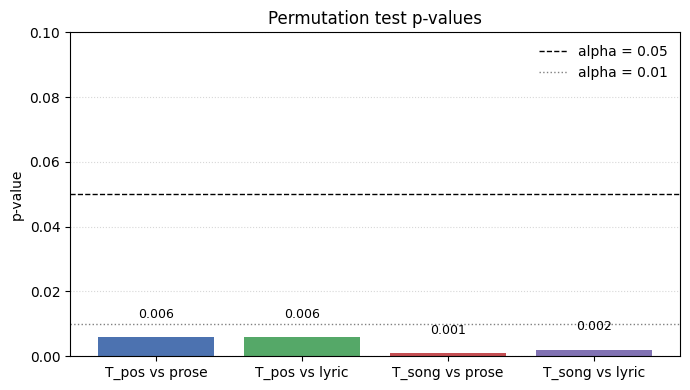

In [34]:
import matplotlib.pyplot as plt

labels = [
    "T_pos vs prose",
    "T_pos vs lyric",
    "T_song vs prose",
    "T_song vs lyric",
]
values = [p_pos_prose, p_pos_lyric, p_song_prose, p_song_lyric]
colors = ["#4c72b0", "#55a868", "#c44e52", "#8172b3"]

fig, ax = plt.subplots(figsize=(7, 4))
bars = ax.bar(labels, values, color=colors)
ax.axhline(0.05, color="black", linestyle="--", linewidth=1, label="alpha = 0.05")
ax.axhline(0.01, color="grey", linestyle=":", linewidth=1, label="alpha = 0.01")
ax.set_ylabel("p-value")
ax.set_title("Permutation test p-values")
ax.set_ylim(0, max(max(values), 0.05) + 0.05)
ax.grid(axis="y", linestyle=":", alpha=0.5)

for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width() / 2, val + 0.005, f"{val:.3f}", ha="center", va="bottom", fontsize=9)

ax.legend(frameon=False)
plt.tight_layout()


## Histograms 

It can be interesting to plot the observed distribution and the means of the two baseline distributions as histrograms with the bins of normalized compatibility scores. 

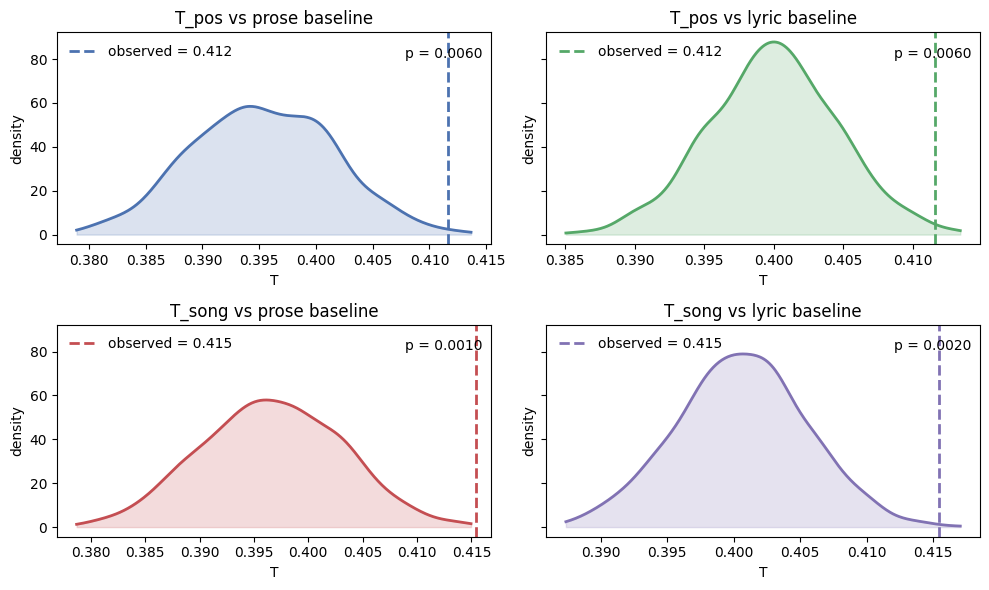

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


def plot_baseline_kde(ax, baseline, obs, title, color, pval):
    arr = np.asarray(baseline, dtype=float)
    obs_f = float(obs)
    if arr.std() == 0:
        ax.axvline(arr[0], color=color, linewidth=2, label=f"observed = {obs_f:.3f}")
        ax.set_title(title)
        ax.set_xlabel("T")
        ax.set_ylabel("density")
        ax.legend(frameon=False)
        ax.text(0.98, 0.9, f"p = {pval:.4f}", ha="right", va="center", transform=ax.transAxes)
        return

    kde = gaussian_kde(arr)
    xs = np.linspace(arr.min(), arr.max(), 400)
    ys = kde(xs)
    ax.plot(xs, ys, color=color, linewidth=2)
    ax.fill_between(xs, ys, color=color, alpha=0.2)
    ax.axvline(obs_f, color=color, linestyle="--", linewidth=2, label=f"observed = {obs_f:.3f}")
    ax.set_title(title)
    ax.set_xlabel("T")
    ax.set_ylabel("density")
    ax.legend(frameon=False)
    ax.text(0.98, 0.9, f"p = {pval:.4f}", ha="right", va="center", transform=ax.transAxes)


fig, axes = plt.subplots(2, 2, figsize=(10, 6), sharey=True)
plot_baseline_kde(axes[0, 0], T_exp_pos_prose_list, T_obs_pos_triads, "T_pos vs prose baseline", "#4c72b0", p_pos_prose)
plot_baseline_kde(axes[0, 1], T_exp_pos_lyric_list, T_obs_pos_triads, "T_pos vs lyric baseline", "#55a868", p_pos_lyric)
plot_baseline_kde(axes[1, 0], T_exp_song_prose_list, T_obs_song_triads, "T_song vs prose baseline", "#c44e52", p_song_prose)
plot_baseline_kde(axes[1, 1], T_exp_song_lyric_list, T_obs_song_triads, "T_song vs lyric baseline", "#8172b3", p_song_lyric)
plt.tight_layout()
